<a href="https://colab.research.google.com/github/gerardPlanella/NLP1_UvA_2022/blob/main/Assignment1/NLP1_2022_Practical_1_(student_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [42]:
!python --version

Python 3.7.15


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [43]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

#Added libraries
from collections import defaultdict
import functools
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [44]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2022-11-15 10:55:56--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon.1’

sent_lexicon.1      100%[===================>] 647.05K  --.-KB/s    in 0.004s  

2022-11-15 10:55:58 (152 MB/s) - ‘sent_lexicon.1’ saved [662577/662577]

--2022-11-15 10:55:58--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubuserconte

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [45]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  """
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print(r["content"])
  """
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
pos_tags = []
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      if pos_tag not in pos_tags :
        pos_tags.append(pos_tag)

"""
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))

print("Pos Tags: " + str(pos_tags))
"""



Total number of reviews: 2000 

Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
Damn/JJ that/IN Y2K/CD bug/NN ./.
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.


'\nprint("\nNumber of word types:", len(c))\nprint("Number of word tokens:", sum(c.values()))\n\nprint("\nMost common tokens:")\nfor token, count in c.most_common(20):\n  print("%10s : %8d" % (token, count))\n\nprint("Pos Tags: " + str(pos_tags))\n'

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [46]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  pos_tags = []
  types = []
  mags = []
  polarities = []
  line_cnt = 0
  for line in f:
    line_cnt += 1
    if(line_cnt == 1):
      print("First line: " + line)
    word = line.strip().split(" ")[2].split("=")[1]
    pos_tag = line.strip().split(" ")[3].split("=")[1]
    mag = line.strip().split(" ")[0].split("=")[1]
    polarity = line.strip().split(" ")[5].split("=")[1]
    if  pos_tag not in pos_tags:
      pos_tags.append(pos_tag)
    if mag not in mags:
      mags.append(mag)
    if polarity not in polarities:
      polarities.append(polarity)
    

  print("Mags:")
  print(mags)
  print("POS Tags:")
  print(pos_tags)
  print("Polarities: ")
  print(polarities)
  print("Lines:")
  print(line_cnt)

  

First line: type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative

Mags:
['weaksubj', 'strongsubj']
POS Tags:
['adj', 'noun', 'verb', 'anypos', 'adverb']
Polarities: 
['negative', 'positive', 'neutral', 'both']
Lines:
8222


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [47]:
class WordInfo():
  def __init__(self, word, polarity, weight, pos_tag):
    self.polarity = polarity
    self.word = word
    self.weight = weight
    self.pos_tag = pos_tag
  
  @classmethod
  def extractWord(cls, in_str):
    params = in_str.split(" ")
    priorpolarity = params[5].split("=")[1].lower()

    if priorpolarity == "negative":
      polarity = -1
    elif priorpolarity == "positive":
      polarity = 1
    elif priorpolarity == "neutral":
      polarity = 0
    else:
      polarity = 0

    word = params[2].split("=")[1]
    weight = params[0].split("=")[1]

    if(weight.lower() == "weaksubj"):
      weight = 1
    else:
      weight = 2

    pos_tag = params[3].split("=")[1]

    if pos_tag == "adj":
      pos_tag = "JJ"
    elif pos_tag == "noun":
      pos_tag = "NN"
    elif pos_tag == "verb":
      pos_tag = "VB"
    elif pos_tag == "adverb":
      pos_tag = "RB"


    return cls(word, polarity, weight, pos_tag)
    



class Lexicon():
  __slots__ = ["wordDict"]

  def __init__(self, lexicon_title = "sent_lexicon") -> None:
    self.wordDict = defaultdict(list)
    with open(lexicon_title, mode="r", encoding="utf-8") as f:
      for line in f:
        wordInfo = WordInfo.extractWord(line.strip())
        self.wordDict[wordInfo.word].append(wordInfo)

  def obtainWordInfo(self, word, pos_tag):
    if(word not in self.wordDict.keys()):
      return None
    wordList = self.wordDict[word]
    for wordInfo in wordList:
      lex_pos = wordInfo.pos_tag
      if(pos_tag[0:1] == lex_pos or pos_tag == lex_pos):
        return wordInfo
    return None
    
  
  def classifyBinaryScore(self, review, threshold):
    content = review["content"]

    binaryScore = 0
    for sentence in content: 
      for word, pos_tag in sentence:
        wordInfo = self.obtainWordInfo(word.lower(), pos_tag)
        if(wordInfo is not None):
          #print(f"FOUND Word \"{word}\" with POS Tag {pos_tag} has polarity {wordInfo.polarity}")
          binaryScore+=wordInfo.polarity
        else:
          pass
          #print(f"Word \"{word}\" with POS Tag {pos_tag} not found in Lexicon")

    if binaryScore > threshold :
      return 1
    else:
      return 0


  def classifyWeightedScore(self, review, threshold):
    content = review["content"]

    weightedScore = 0
    for sentence in content: 
      for word, pos_tag in sentence:
        wordInfo = self.obtainWordInfo(word, pos_tag)

        if(wordInfo is not None):
          #print(f"FOUND Word \"{word}\" with POS Tag {pos_tag} has polarity {wordInfo.polarity} and weight {wordInfo.weight}")
          weightedScore+=(wordInfo.polarity * wordInfo.weight)
        else:
          pass
          #print(f"Word \"{word}\" with POS Tag {pos_tag} not found in Lexicon")
    
    if weightedScore > threshold :
      return 1
    else:
      return 0

lexicon = Lexicon()  




In [48]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification. 

token_results = []
n_correct = 0
threshold = 4

for idx, review in enumerate(reviews):
  token_results.append(lexicon.classifyBinaryScore(review, threshold))
  if(token_results[idx] == 1 and review["sentiment"] == "POS") or (token_results[idx] == 0 and review["sentiment"] == "NEG"):
    n_correct +=1

    
token_accuracy = (n_correct / len(reviews)) * 100
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 66.60


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [49]:
lexicon = Lexicon() 

In [50]:
magnitude_results = []

n_correct = 0
threshold = 3

for idx, review in enumerate(reviews):
  magnitude_results.append(lexicon.classifyWeightedScore(review, threshold))
  if(magnitude_results[idx] == 1 and review["sentiment"] == "POS") or (magnitude_results[idx] == 0 and review["sentiment"] == "NEG"):
    n_correct +=1


magnitude_accuracy = (n_correct / len(reviews)) * 100
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 67.60


#### (Q.1.3) Make a barplot of the two results (0.5pt)

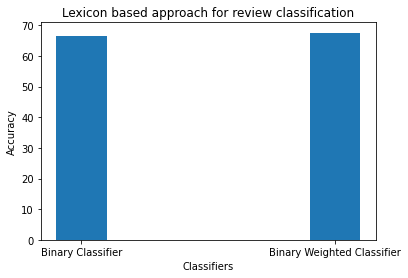

In [51]:
d = {'Binary Classifier': token_accuracy, 'Binary Weighted Classifier': magnitude_accuracy}
classifiers = list(d.keys())
acc = list(d.values())

plt.bar(classifiers, acc, width = 0.2)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Lexicon based approach for review classification")
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

The fixed threshold can pose problems as depending on our dataset we would have to manually tune said threshold. Furthermore, if the length of the reviews in our dataset is not close to constant the longer reviews will tend to get higher scores than the shorter ones as they will probably contain more positive words, making them more probable to be classified as positive.

A solution to this problem would be calculating a threshold that would take into account the review length, by, for example, using the length of the document as a mutiplying factor to the threshold.



In [52]:
class ImprovedLexicon(Lexicon):

  def __init__(self, lexicon_title = "sent_lexicon"):
    super().__init__(lexicon_title)
    self.THRESHOLD_FACTOR = 0.003
    self.THRESHOLD_FACTOR_W = 0.003
  

  @staticmethod
  def calculateNWords(review):
    cnt = 0
    for sentence in review["content"]:
      cnt+=len(sentence)
    return cnt

  def classifyBinaryScoreImproved(self, review):
    improvedThreshold = self.calculateNWords(review)*self.THRESHOLD_FACTOR
    return self.classifyBinaryScore(review, improvedThreshold)

  def classifyWeightedScoreImproved(self, review):
    improvedThreshold = self.calculateNWords(review)*self.THRESHOLD_FACTOR_W
    return self.classifyWeightedScore(review, improvedThreshold)


lex = ImprovedLexicon()


magnitude_results = []

n_correct = 0
threshold = 3

for idx, review in enumerate(reviews):
  magnitude_results.append(lex.classifyWeightedScoreImproved(review))
  if(magnitude_results[idx] == 1 and review["sentiment"] == "POS") or (magnitude_results[idx] == 0 and review["sentiment"] == "NEG"):
    n_correct +=1


magnitude_accuracy = (n_correct / len(reviews)) * 100
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 67.30


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

If we skip all the unseen words for one sentiment class, then the words with 0 count in our vocabulary will not be taken into account. This means that, if for example, we dont take into account unseen words appearing in positive reviews, we will have a lot of words missing in our negative sentiment vocabulary, which on testing data will make our classifier positively biased.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [53]:
def separateData(reviews, training_idx_start = 0, training_idx_end = 899, testing_idx_start = 900, testing_idx_end = 999):
  training_set = []
  test_set = []
  class_freq = {}
  for review in reviews:
    if review["cv"]<= training_idx_end and review["cv"] >= training_idx_start:
      training_set.append(review)
      if(review["sentiment"] not in class_freq.keys()):
        class_freq[review["sentiment"]] = 1
      else:
        class_freq[review["sentiment"]]+= 1
    elif review["cv"]<= testing_idx_end and review["cv"] >= testing_idx_start:
      test_set.append(review)
      if(review["sentiment"] not in class_freq.keys()):
        class_freq[review["sentiment"]] = 0 #So we have all classes in dict keys

  return training_set, test_set, class_freq

def trainNBClassifier(reviews, class_freq, smoothing = False, stem_func = lambda x:x, n_grams = [1]):
  features = {}
  N_docs = len(reviews)

  vocab = {}

  for idx, review in enumerate(reviews):
    if(idx not in vocab.keys()):
      vocab[idx] = [review["sentiment"], {}]
    for sentence in review["content"]:
      unigrams = [word[0] for word in sentence]
      for n in n_grams:
        if(n not in vocab[idx][1].keys()):
          vocab[idx][1][n] = []
        #We iterate through our list of ngranms and create our vocabulary
        tokens = ngrams(unigrams, n)
        token_list = [] 
        for token in tokens:
          #Apply stemming function to tokems, default function doesn't modify them
          stem_token = stem_func(" ".join(token).lower())
          token_list.append(stem_token)
          if stem_token not in features.keys():
            features[stem_token] = 1
          else:
            features[stem_token] += 1
        vocab[idx][1][n] += token_list
      

  #Calculate Prior probabilities
  prior = {}
  for cl in class_freq.keys():
    Nc = class_freq[cl]
    prior[cl] = Nc / N_docs


  sentimentWordCount = defaultdict(dict)

  #Create frequency vocab
  for cv in vocab:
    sentiment = vocab[cv][0]
    for n in vocab[cv][1].keys():
      for word_low in vocab[cv][1][n]:
        if word_low in sentimentWordCount[sentiment].keys():
          sentimentWordCount[sentiment][word_low] += 1

        if smoothing:
          if word_low not in sentimentWordCount["NEG"].keys():
            sentimentWordCount["NEG"][word_low] = 1 if sentiment == "NEG" else 0
          if word_low not in sentimentWordCount["POS"].keys():
            sentimentWordCount["POS"][word_low] = 1 if sentiment == "POS" else 0
            continue
        elif word_low not in sentimentWordCount[sentiment].keys():
          sentimentWordCount[sentiment][word_low] = 1

  #Perform intersection of both dictionaries
  if(not smoothing):
    words_to_remove = list(sentimentWordCount["POS"].keys() ^ sentimentWordCount["NEG"].keys())
    list(map(lambda x: functools.partial(sentimentWordCount["POS"].pop, x, None)(), words_to_remove))
    list(map(lambda x: functools.partial(sentimentWordCount["NEG"].pop, x, None)(), words_to_remove))
    list(map(lambda x: functools.partial(features.pop, x, None)(), words_to_remove))  

  smoothing_factor = 0 if not smoothing else 1

  cond_prob = defaultdict(dict)

  #Calculate conditional Probabilities
  for sent in sentimentWordCount.keys():
    denominator = (np.sum(np.array(list(sentimentWordCount[sent].values()))) \
              + (smoothing_factor * len(sentimentWordCount[sent].keys())))
    
    for word in sentimentWordCount[sent].keys():
      numerator = sentimentWordCount[sent][word]
      numerator = numerator + smoothing_factor
      
      cond_prob[sent][word] = numerator / denominator

  return features, cond_prob, prior


def predict_NB(features, cond_prob, prior, review, stem_func = lambda x:x, n_grams = [1]):
  score = {}
  words = []

  vocab = defaultdict(list)

  for sentence in review["content"]:
    unigrams = [word[0] for word in sentence]
    for n in n_grams:
      tokens = ngrams(unigrams, n)
      token_list = [] 
      for token in tokens:
        stem_token = stem_func(" ".join(token).lower())
        token_list.append(stem_token)
      vocab[n] += token_list

  for n in vocab:
    for word in vocab[n]:
      if(word in features.keys()):
        words.append(word)

  for cls in cond_prob:
    score[cls] = np.log(prior[cls])
    for word in words:
      if(word in cond_prob[cls]):
        score[cls]+= np.log(cond_prob[cls][word])
  
  return max(score, key=score.get)


def test_NB_batch(features, cond_prob, prior, reviews, stem_func = lambda x:x, n_grams = [1]):
  scores = []
  if(len(reviews) <= 0):
    return 0

  for review in reviews:
    if predict_NB(features, cond_prob, prior, review, stem_func, n_grams) == review["sentiment"]:
      scores.append(1)
    else:
      scores.append(0)
  return (np.sum(scores)*100/len(scores))

In [54]:
training_set, test_set, class_freq = separateData(reviews)
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = False)

print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set)}%")
print(f"Number of Features {len(features.keys())}")

Accuracy: 83.5%
Number of Features 18799


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In the case where 90% of our data instances are of positive movie reviews, accuracy would not be a good measure to evaluate our classifier because the two classes (positive and negative reviews) are unbalanced. So, if in 1000 reviews only 100 are negative and we have a classifier that classsifies every review as positive then this classifier will have 900 true positives and only 100 false positives, so eventually we will have an accuracy of 90% but this would obviously be a bad classifier. This shows that in the case where we want to discover something rare, accuracy is not a good metric.

In [55]:
training_set, test_set, class_freq = separateData(reviews, training_idx_start = 0, training_idx_end = 89, testing_idx_start = 900, testing_idx_end = 909)
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = False)
print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set)}%")
print(f"Number of Features {len(features.keys())}")

Accuracy: 65.0%
Number of Features 4385


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [56]:
training_set, test_set, class_freq = separateData(reviews)
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = True)
print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set)}%")
print(f"Number of Features {len(features.keys())}")

Accuracy: 82.5%
Number of Features 45348


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [57]:
def cross_val(reviews, fold_size =10, stem_func = lambda x:x):
  
  class_freq = {}
  k_folds = []
  accuracies = []
  var_acc = []
  acc_sum = 0

  for i in range(fold_size):
    split = []
    for j, review in enumerate(reviews):
        if j%fold_size == i:
         split.append(review)
         if(review["sentiment"] not in class_freq.keys()):
          class_freq[review["sentiment"]] = 1
        else:
          class_freq[review["sentiment"]]+= 1
    k_folds.append(split)  

  avg_n_features = 0    

  for i in range(fold_size):
    print("Evaluating Fold " + str(i) + "...")
    training_set = []
    test_set = []
    for j in range(len(k_folds)):
      if i == j:
        test_set+=k_folds[j]
      else:
        training_set+=k_folds[j]
    features, cond_prob, prior = trainNBClassifier(training_set, class_freq, \
                                smoothing = True, stem_func=stem_func)
    acc = test_NB_batch(features, cond_prob, prior, test_set)
    acc_sum += acc
    print("Accuracy for Fold " + str(i) + "-> " + str(acc))
    accuracies.append(acc)
    avg_n_features += len(features.keys())

  avg_n_features/=len(accuracies)
  mean_acc = acc_sum / len(accuracies)
  var_acc = 0
  for acc in accuracies:
    var_acc = var_acc + (acc - mean_acc)**2
  var_acc/=len(accuracies)
  
  return accuracies, var_acc, mean_acc, avg_n_features

In [58]:
accuracies, var_acc, mean_acc, n_features = cross_val(reviews, fold_size =10)
print("Mean Accuracy: " + str(mean_acc))

Evaluating Fold 0...
Accuracy for Fold 0-> 79.0
Evaluating Fold 1...
Accuracy for Fold 1-> 83.5
Evaluating Fold 2...
Accuracy for Fold 2-> 80.5
Evaluating Fold 3...
Accuracy for Fold 3-> 82.5
Evaluating Fold 4...
Accuracy for Fold 4-> 78.0
Evaluating Fold 5...
Accuracy for Fold 5-> 84.5
Evaluating Fold 6...
Accuracy for Fold 6-> 83.0
Evaluating Fold 7...
Accuracy for Fold 7-> 77.5
Evaluating Fold 8...
Accuracy for Fold 8-> 83.0
Evaluating Fold 9...
Accuracy for Fold 9-> 84.0
Mean Accuracy: 81.55


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance. 

In [59]:
print(f"Variance -> {var_acc}")

Variance -> 6.022499999999999


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [60]:
#Our naive bayes class already implements this, we only need to initialise our stemmer
stemmer = PorterStemmer()

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [61]:
#Passing the stemming function already 
accuracies, var_acc, mean_acc, n_features = cross_val(reviews, fold_size =10, stem_func=stemmer.stem)
print("Mean Accuracy: " + str(mean_acc))
print("Number of features: " + str(n_features))

Evaluating Fold 0...
Accuracy for Fold 0-> 75.0
Evaluating Fold 1...
Accuracy for Fold 1-> 80.0
Evaluating Fold 2...
Accuracy for Fold 2-> 78.0
Evaluating Fold 3...
Accuracy for Fold 3-> 80.0
Evaluating Fold 4...
Accuracy for Fold 4-> 77.0
Evaluating Fold 5...
Accuracy for Fold 5-> 79.5
Evaluating Fold 6...
Accuracy for Fold 6-> 79.0
Evaluating Fold 7...
Accuracy for Fold 7-> 76.0
Evaluating Fold 8...
Accuracy for Fold 8-> 79.5
Evaluating Fold 9...
Accuracy for Fold 9-> 80.5
Mean Accuracy: 78.45
Number of features: 32521.0


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [62]:
training_set, test_set, class_freq = separateData(reviews)
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = False, stem_func=stemmer.stem)
print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set)}%")
print(f"Number of Features {len(features.keys())}")

Accuracy: 78.0%
Number of Features 13326


We can see how the number of features decreases drastically.


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [63]:
n_features = {}
print("----- Unigrams (Original Implementation) -----")
training_set, test_set, class_freq = separateData(reviews)
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = False)
print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set)}%")
print(f"Number of Features {len(features.keys())}")
n_features["unigrams"] = len(features.keys())


print("----- Bigrams -----")
training_set, test_set, class_freq = separateData(reviews)
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = False, n_grams=[2])
print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set, n_grams=[2])}%")
print(f"Number of Features {len(features.keys())}")


print("----- Unigrams and Bigrams -----")
training_set, test_set, class_freq = separateData(reviews)
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = False, n_grams=[1, 2])
print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set, n_grams=[1, 2])}%")
print(f"Number of Features {len(features.keys())}")
n_features["unigrams_bigrams"] = len(features.keys())

print("----- Unigrams, Bigrams and Trigrams -----")
features, cond_prob, prior = trainNBClassifier(training_set, class_freq, smoothing = False, n_grams=[1, 2, 3])
print(f"Accuracy: {test_NB_batch(features, cond_prob, prior, test_set, n_grams=[1, 2, 3])}%")
print(f"Number of Features {len(features.keys())}")
n_features["unigrams_bigrams_trigrams"] = len(features.keys())


----- Unigrams (Original Implementation) -----
Accuracy: 83.5%
Number of Features 18799
----- Bigrams -----
Accuracy: 84.0%
Number of Features 74856
----- Unigrams and Bigrams -----
Accuracy: 83.5%
Number of Features 93655
----- Unigrams, Bigrams and Trigrams -----
Accuracy: 83.0%
Number of Features 156730



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


We would expect to have a linear increase in our BoW features which is also shown in our feature size plotted below.

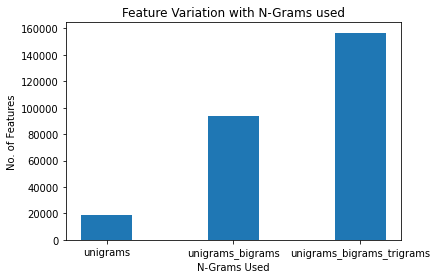

In [64]:
keys = n_features.keys()
values = n_features.values()

plt.bar(keys, values, width = 0.4)
  
plt.xlabel("N-Grams Used") 
plt.ylabel("No. of Features") 
plt.title("Feature Variation with N-Grams used") 
plt.show() 

# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [65]:
def separateDataSVM(reviews, training_idx_start = 0, training_idx_end = 899, testing_idx_start = 900, testing_idx_end = 999):
  training_set = []
  test_set = []
  review_content = []
   

  for review in reviews:
    if review["cv"]<= training_idx_end and review["cv"] >= training_idx_start:
      training_set.append(review)
    elif review["cv"]<= testing_idx_end and review["cv"] >= testing_idx_start:
      test_set.append(review)

  training_df = DataFrame(training_set, columns=['sentiment', 'content'])
  testing_df = DataFrame(test_set, columns=['sentiment','content'])
  return training_df, testing_df

def preprocess(df, pos, closed_classes):
  fixed_set = []
  for review in df:
    r = ""
    for sentence in review:
      for word, tag in sentence:
        if closed_classes:
          if not (tag.startswith('NN') or tag.startswith('VB') or tag.startswith('JJ') or tag.startswith('RB')):
            continue
        if pos:
          r += word.lower() + "_" + tag + " "
        else:
          r += word.lower() + " "
    fixed_set.append(r)
  fixed_df = [x.lower() for x in fixed_set]
  return fixed_df

In [66]:
def acc_svm(pred, y):
  scores = []
  if(len(pred) <= 0):
    return 0
  for i, p in enumerate(pred):
    if p == y[i]:
      scores.append(1)
    else:
      scores.append(0)
  return (np.sum(scores)*100/len(scores))

def cross_val_svm(reviews, fold_size =10, pos=False, closed_classes=False, stem_func = lambda x:x):
  k_folds = []
  accuracies = []
  var_acc = []
  acc_sum = 0
  cntdf = CountVectorizer(stop_words='english')

  for i in range(fold_size):
    split = []
    for j, review in enumerate(reviews):
        if j%fold_size == i:
         split.append(review)
    k_folds.append(split)      

  for i in range(fold_size):
    print("Evaluating Fold " + str(i) + "...")
    training_set = []
    test_set = []
    for j in range(len(k_folds)):
      if i == j:
        test_set+=k_folds[j]
      else:
        training_set+=k_folds[j]
    training_df = DataFrame(training_set, columns=['sentiment', 'content'])
    testing_df = DataFrame(test_set, columns=['sentiment','content'])

    train_x, train_y = training_df['content'], training_df['sentiment']
    test_x, test_y = testing_df['content'], testing_df['sentiment']

    train_x_svm = preprocess(train_x, pos, closed_classes)
    test_x_svm = preprocess(test_x, pos, closed_classes)
    
    train_vectors = cntdf.fit_transform(train_x_svm)
    test_vectors = cntdf.transform(test_x_svm)

    clf = svm.SVC()
    clf.fit(train_vectors, train_y)

    pred = clf.predict(test_vectors)

    acc = acc_svm(pred, test_y)
    acc_sum += acc
    accuracies.append(acc)

  mean_acc = acc_sum / len(accuracies)
  var_acc = 0
  for acc in accuracies:
    var_acc = var_acc + (acc - mean_acc)**2
  var_acc/=len(accuracies)
  
  return accuracies, var_acc, mean_acc

In [67]:
acc, var_acc, mean_acc = cross_val_svm(reviews)
for fold, accuracy in enumerate(acc):
  print(f"Accuracy for fold {fold} -> {accuracy}")

print("Mean Accuracy: " + str(mean_acc))

Evaluating Fold 0...
Evaluating Fold 1...
Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...
Evaluating Fold 6...
Evaluating Fold 7...
Evaluating Fold 8...
Evaluating Fold 9...
Accuracy for fold 0 -> 75.0
Accuracy for fold 1 -> 85.0
Accuracy for fold 2 -> 78.5
Accuracy for fold 3 -> 84.0
Accuracy for fold 4 -> 77.0
Accuracy for fold 5 -> 84.0
Accuracy for fold 6 -> 83.5
Accuracy for fold 7 -> 81.5
Accuracy for fold 8 -> 81.5
Accuracy for fold 9 -> 78.0
Mean Accuracy: 80.8


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [68]:
acc, var_acc, mean_acc = cross_val_svm(reviews, pos=True)
for fold, accuracy in enumerate(acc):
  print(f"Accuracy for fold {fold} -> {accuracy}")

print("Mean Accuracy: " + str(mean_acc))

Evaluating Fold 0...
Evaluating Fold 1...
Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...
Evaluating Fold 6...
Evaluating Fold 7...
Evaluating Fold 8...
Evaluating Fold 9...
Accuracy for fold 0 -> 73.0
Accuracy for fold 1 -> 72.5
Accuracy for fold 2 -> 75.5
Accuracy for fold 3 -> 72.5
Accuracy for fold 4 -> 67.5
Accuracy for fold 5 -> 81.0
Accuracy for fold 6 -> 76.0
Accuracy for fold 7 -> 72.0
Accuracy for fold 8 -> 77.0
Accuracy for fold 9 -> 74.5
Mean Accuracy: 74.15


We can see that our classifier performs worse when taking into account POS tags for words, we belive this is the case as incorporating POS tags does not add any relevant information that will help our model classify the reviews better. What we can experience when taking into account POS tags is an increase of words in our vocabulary with generally lower frequencies caused by words being used in many different forms in our reviews.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [69]:
acc, var_acc, mean_acc = cross_val_svm(reviews, closed_classes=True)
for fold, accuracy in enumerate(acc):
  print(f"Accuracy for fold {fold} -> {accuracy}")

print("Mean Accuracy: " + str(mean_acc))

Evaluating Fold 0...
Evaluating Fold 1...
Evaluating Fold 2...
Evaluating Fold 3...
Evaluating Fold 4...
Evaluating Fold 5...
Evaluating Fold 6...
Evaluating Fold 7...
Evaluating Fold 8...
Evaluating Fold 9...
Accuracy for fold 0 -> 77.0
Accuracy for fold 1 -> 82.5
Accuracy for fold 2 -> 80.0
Accuracy for fold 3 -> 82.5
Accuracy for fold 4 -> 78.0
Accuracy for fold 5 -> 83.5
Accuracy for fold 6 -> 83.5
Accuracy for fold 7 -> 83.0
Accuracy for fold 8 -> 84.5
Accuracy for fold 9 -> 79.5
Mean Accuracy: 81.4


Discarding closed-class words from our data doesn't enhance the performance of our classifier drastically. More specifically, we observe a slight (0.6%) increase in it's performance. This is the case because it's the open-class words that mostly express emotion. Although, using both closed-class and open-class words result in better classification performance.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


To do sentiment classification for movie reviews we implemented a Lexicon-based approach, a Naive Bayes approach and an SVM approach. With the lexicon-based approach, we achieved an accuracy of 67%, although we managed to get a slight increase of 1% when incorporating the magnitude of the sentiment. The accuracy achieved is quite low compared to the other approaches. This might be the case because while the lexicon-based approach is intuitive and relatively easy to implement it only evaluates individual words that exist in the lexicon and also ignores the context in which each word is encountered.

The Naive Bayes classifier achieved an accuracy of 83.5%. This is significantly better than the 67% achieved by the lexicon-based classifier and it happens probably because it is a probabilistic classifier that incorporates prior knowledge and uses conditional probabilities of a word occurring in a positive or negative review. It assumes that features are independent so their relative position in a sentence is not taken into account. Lack of sufficient training data can lead to poor classification in case of unseen words. Poor classification might also occur in the case of unbalanced data. To address this problem an efficient technique to use is smoothing. In addition, to make sure our classifier generalizes well on new data we can use n-fold cross-validation. In our implementation, we achieved an average accuracy of all folds of 81.55% which is very close to the accuracy achieved without it. To reduce the size of our vocabulary to not include words with the same stem and account for them as one word we used stemming but this resulted in worse results either because the stemmer was not that good or because the extra words in our vocabulary were indeed helpful. Finally, to capture context (consecutive words) in our reviews we used n-grams. Specifically, we got a slight increase when only using bigrams leading to an accuracy of 84% while we got the same accuracy of 83.5% when using unigrams and bigrams. This means that the use of n-grams can be helpful but they don't always manage to capture the context we are looking for.

Finally, the SVM approach led to an accuracy of 80.7%. This approach is easy to implement and does an adequate job in sentiment classification. Incorporating POS tags doesn't make a big difference because they don't provide any useful semantic information for the SVM classifier. Finally discarding closed-class words can increase the performance since the sentiment of reviews is mostly captured in the open-class words.

# Submission 


In [70]:
# Write your names and student numbers here:
# Gerard Planella Fontanillas #14244950
# Chrysoula Pozrikidou #14609797

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 